In [1]:
import pandas as pd
import numpy as np
from scipy.stats import uniform, randint
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import scikitplot as skplt
import matplotlib.pyplot as plt

### Load Dataset

In [2]:
DF_PATH = "data/lifestyle_sustainability_data_standardized.csv"

In [3]:
df_raw = pd.read_csv(DF_PATH)
print(df_raw.shape)
print(df_raw.columns)
print(df_raw.dtypes)
df_raw.head()

(499, 13)
Index(['EnvironmentalAwareness', 'CommunityInvolvement',
       'MonthlyElectricityConsumption', 'MonthlyWaterConsumption',
       'PhysicalActivities', 'DietType_Balanced',
       'DietType_Mostly Animal-Based', 'DietType_Mostly Plant-Based',
       'TransportationMode_Bike', 'TransportationMode_Car',
       'TransportationMode_Public Transit', 'TransportationMode_Walk',
       'Rating'],
      dtype='object')
EnvironmentalAwareness               float64
CommunityInvolvement                 float64
MonthlyElectricityConsumption        float64
MonthlyWaterConsumption              float64
PhysicalActivities                   float64
DietType_Balanced                    float64
DietType_Mostly Animal-Based         float64
DietType_Mostly Plant-Based          float64
TransportationMode_Bike              float64
TransportationMode_Car               float64
TransportationMode_Public Transit    float64
TransportationMode_Walk              float64
Rating                             

,EnvironmentalAwareness,CommunityInvolvement,MonthlyElectricityConsumption,MonthlyWaterConsumption,PhysicalActivities,DietType_Balanced,DietType_Mostly Animal-Based,DietType_Mostly Plant-Based,TransportationMode_Bike,TransportationMode_Car,TransportationMode_Public Transit,TransportationMode_Walk,Rating
0,1.445313,1.385178,-1.594895,-1.340155,1.347737,-0.680693,-0.636894,1.238142,1.786974,-0.624477,-0.571951,-0.553428,5
1,0.699490,-0.034132,-0.348649,-0.114045,-0.062160,1.469091,-0.636894,-0.807662,-0.559605,-0.624477,1.748402,-0.553428,4
2,-0.792157,-1.453442,0.897597,1.112064,-1.472057,-0.680693,1.570120,-0.807662,-0.559605,1.601339,-0.571951,-0.553428,1
3,0.699490,-0.034132,-1.179480,-0.931452,1.347737,-0.680693,-0.636894,1.238142,-0.559605,-0.624477,-0.571951,1.806919,5
4,-0.046334,-1.453442,0.066766,0.294658,-0.062160,1.469091,-0.636894,-0.807662,-0.559605,-0.624477,1.748402,-0.553428,3


In [4]:
df_raw.groupby("Rating").size()

Rating
1     97
2     34
3    101
4     91
5    176
dtype: int64

#### Prepare X and Y

In [5]:
RANDOM_STATE = 26
test_size = 0.05 # test set
val_size = 0.1 # validation set

In [6]:
df = df_raw.copy()
df.shape

(499, 13)

In [7]:
df["Rating"] = df["Rating"].apply(lambda rating: rating - 1) # required to fit XGBoost
target_column = df.pop("Rating")
X = df.to_numpy()
Y = np.array(target_column.to_list())
X.shape, Y.shape

((499, 12), (499,))

Train/Test Split (Stratified Test)

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, stratify=Y, random_state=RANDOM_STATE) # stratified train/test
print(f"X_train: {X_train.shape} | Y_train: {Y_train.shape}")
print(f"X_test: {X_test.shape} | Y_test: {Y_test.shape}")
print(f"Y_test label distribution: {np.unique(Y_test, return_counts=True)}")

X_train: (474, 12) | Y_train: (474,)
X_test: (25, 12) | Y_test: (25,)
Y_test label distribution: (array([0, 1, 2, 3, 4]), array([5, 2, 5, 4, 9], dtype=int64))


---

In [9]:
number_of_splits = 5

stratified_shufflesplit = StratifiedShuffleSplit(n_splits=number_of_splits, test_size=val_size, random_state=RANDOM_STATE)
stratified_shufflesplit

StratifiedShuffleSplit(n_splits=5, random_state=26, test_size=0.1,
            train_size=None)

### Random Forest

### XGBoost

In [10]:
xgb_model = xgb.XGBClassifier(objective='multi:softprob') # XGBClassifier for multi-class classification

In [11]:
xgb_model_params = {
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.01, 0.5),
    "max_depth": randint(2, 6), 
    "n_estimators": randint(50, 150),
}

In [12]:
param_combinations = 50
score_metric = "roc_auc_ovo"

In [13]:
def report_best_score(random_search: RandomizedSearchCV):
    print(f"Best Score: {round(random_search.best_score_, 2)}")
    print(f"Best Params: {random_search.best_params_}")

In [14]:
random_search_xgb = RandomizedSearchCV(xgb_model, param_distributions=xgb_model_params, n_iter=param_combinations, scoring=score_metric, n_jobs=-1, 
                                       cv=stratified_shufflesplit.split(X_train, Y_train), return_train_score=True, refit=True, verbose=6, random_state=RANDOM_STATE)

In [15]:
random_search_xgb.fit(X_train, Y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=<generator object BaseShuffleSplit.split at 0x000001EDB9FBE540>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           impor...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001EDBA071AF0>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001EDBA071C40>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001EDB9FD9C10>},
                   random_state=26, return_train_score=True,
                   scoring='roc_auc_ovo', verbose=6)

In [16]:
random_search_xgb_results = pd.DataFrame(random_search_xgb.cv_results_)
random_search_xgb_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.402708,0.083923,0.061831,0.018656,0.153967,0.269696,3,133,"{'gamma': 0.15396747631248542, 'learning_rate'...",0.837553,...,0.865801,0.033806,40,0.994307,0.994135,0.996084,0.994321,0.994737,0.994717,0.000712
1,0.661296,0.124664,0.109514,0.043016,0.049670,0.064250,4,95,"{'gamma': 0.04967011090577417, 'learning_rate'...",0.856659,...,0.875093,0.030461,14,0.996501,0.996295,0.997679,0.995260,0.995108,0.996169,0.000934
2,0.327220,0.109536,0.072885,0.037284,0.375392,0.417423,3,102,"{'gamma': 0.3753923643238549, 'learning_rate':...",0.827153,...,0.865087,0.028606,42,0.983726,0.984047,0.987350,0.984451,0.981513,0.984217,0.001868
3,0.314896,0.059318,0.074206,0.043922,0.193608,0.327176,5,92,"{'gamma': 0.19360799781883226, 'learning_rate'...",0.866939,...,0.883314,0.031412,1,0.998589,0.998695,0.999141,0.998558,0.998539,0.998704,0.000225
4,0.782776,0.302373,0.082048,0.046697,0.003716,0.221910,5,106,"{'gamma': 0.0037158718740190055, 'learning_rat...",0.862444,...,0.877817,0.035656,4,0.999773,0.999852,0.999865,0.999809,0.999790,0.999818,0.000035


In [17]:
report_best_score(random_search_xgb)

Best Score: 0.88
Best Params: {'gamma': 0.19360799781883226, 'learning_rate': 0.32717567346552856, 'max_depth': 5, 'n_estimators': 92}


In [18]:
best_xgb_model = random_search_xgb.best_estimator_

#### Results on Test Split

In [19]:
Y_test_predicted_proba = best_xgb_model.predict_proba(X_test)
len(Y_test_predicted_proba), Y_test_predicted_proba[:2]

(25,
 array([[0.00138332, 0.00253194, 0.00642823, 0.008989  , 0.9806675 ],
        [0.01963289, 0.2816689 , 0.06756927, 0.36218715, 0.26894176]],
       dtype=float32))

c:\Users\kevin\.conda\envs\h_ls_project_env\Lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


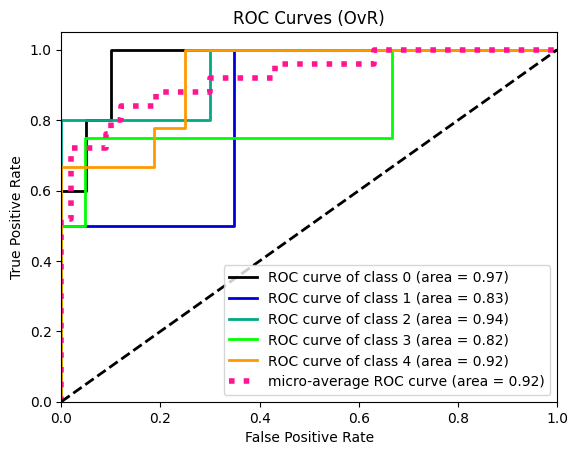

In [20]:
skplt.metrics.plot_roc_curve(Y_test, Y_test_predicted_proba, title="ROC Curves (OvR)", curves=('micro', 'each_class')) # AUC-ROC OvR Approach
plt.show()

c:\Users\kevin\.conda\envs\h_ls_project_env\Lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=FutureWarning)


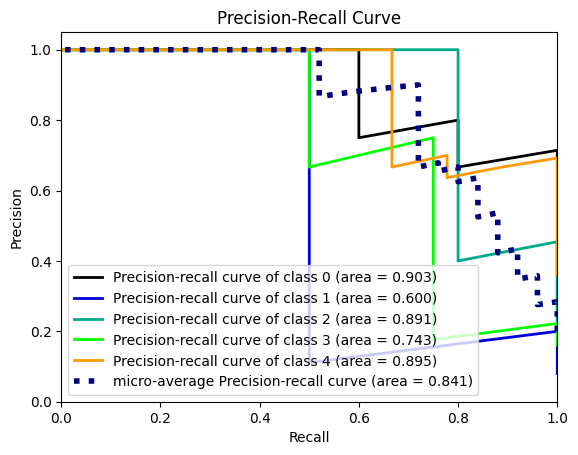

In [21]:
skplt.metrics.plot_precision_recall_curve(Y_test, Y_test_predicted_proba)
plt.show()

#### Feature Importance

In [22]:
for index, feature in enumerate(df.columns):
    print(f"f{index}: {feature}")

f0: EnvironmentalAwareness
f1: CommunityInvolvement
f2: MonthlyElectricityConsumption
f3: MonthlyWaterConsumption
f4: PhysicalActivities
f5: DietType_Balanced
f6: DietType_Mostly Animal-Based
f7: DietType_Mostly Plant-Based
f8: TransportationMode_Bike
f9: TransportationMode_Car
f10: TransportationMode_Public Transit
f11: TransportationMode_Walk


<Axes: title={'center': 'Feature importance (weight)'}, xlabel='Score', ylabel='Features'>

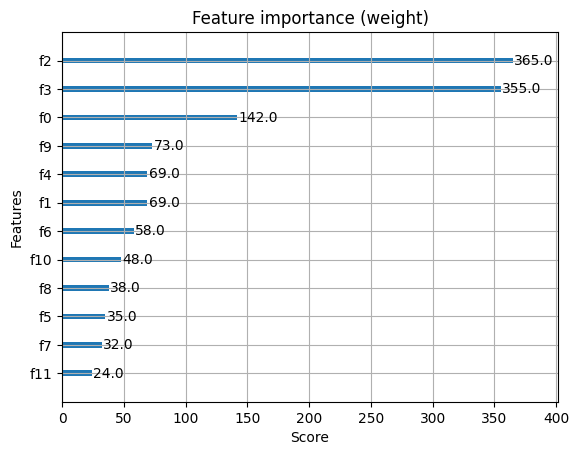

In [23]:
xgb.plot_importance(best_xgb_model, importance_type="weight", title="Feature importance (weight)", xlabel="Score")

<Axes: title={'center': 'Feature importance (gain)'}, xlabel='Score', ylabel='Features'>

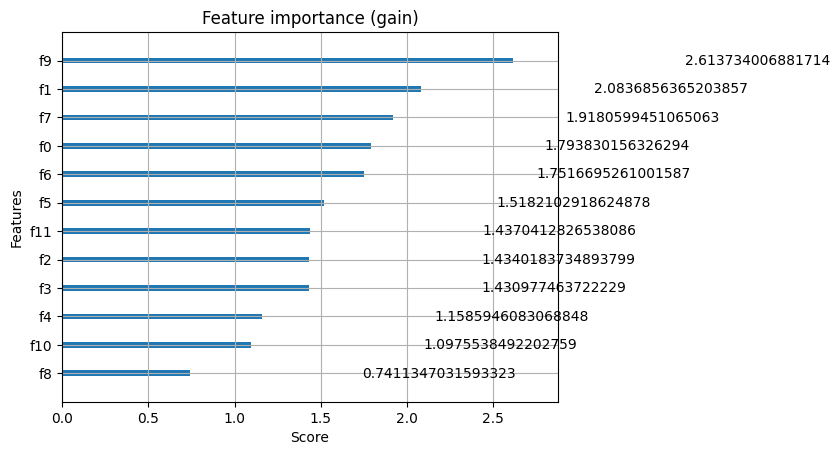

In [24]:
xgb.plot_importance(best_xgb_model, importance_type="gain", title="Feature importance (gain)", xlabel="Score")